In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from psmiles import PolymerSmiles as PS
from torch.utils.data import DataLoader, Dataset, random_split
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
from scipy.sparse import csr_matrix, lil_matrix
import atomInSmiles
from collections import Counter
from IPython.display import clear_output, display
import ipywidgets as widgets
from tqdm.notebook import tqdm
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter, LogLocator, LogFormatterMathtext
from typing import List, Dict, Tuple
from torch.distributions import Normal, kl_divergence
import torch.nn.functional as F
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print(device)
# os.chdir("C:\\Users\\user\\test.venv")
# print(os.getcwd())
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

log_transformer = FunctionTransformer(np.log1p, validate=True)
log_minmax_pipeline = Pipeline(steps=[
    ('log', log_transformer),
    ('minmax', MinMaxScaler())
])

cuda


In [2]:
mm_scaler = MinMaxScaler()
class load_data(Dataset):
    def __init__(self, path):
        #csv 읽기
        self.raw = pd.read_csv(path)

        #SMILES
        self.SMILES = self.raw.iloc[:, 1:2].values
        self.SMILES = np.squeeze(self.SMILES)

        #Li-ion Conductivity
        self.conductivity = self.raw.iloc[:, 6:7].values
        self.conductivity = mm_scaler.fit_transform(self.conductivity.reshape(-1, 1))
        self.conductivity = log_minmax_pipeline.fit_transform(self.conductivity.reshape(-1, 1))

        #Degree of Polymerization
        self.DP = self.raw.iloc[:, 4:5].values
        self.DP = mm_scaler.fit_transform(self.DP.reshape(-1, 1))

        #Transfer Number
        self.tn = self.raw.iloc[:, 10:11].values
        self.tn = mm_scaler.fit_transform(self.tn.reshape(-1, 1))

        self.properties = np.concat((self.conductivity, self.DP, self.tn), axis=-1)
        mean_vec = self.properties.mean(axis=0)
        std_vec  = self.properties.std(axis=0)
        self.properties = (self.properties - mean_vec) / std_vec  # 정규화된 3차원 조건 벡터

        print(self.properties.shape)

        print(self.properties[1])

        #PSMILES 변환
        psmiles = []
        for smiles in self.SMILES:
            ps = PS(smiles)
            ps.canonicalize
            psmiles.append(ps.psmiles)

        #Atom-In-SMILES Encoding
        ais_encoding = []
        for smiles in psmiles:
            ais_encoding.append(atomInSmiles.encode(smiles))
        

        #Atom-In-SMILES Tokenization (Encoder)
        ais_tokens = []
        for smiles in ais_encoding:
            ais_tokens.append(atomInSmiles.smiles_tokenizer("[SOS] " + smiles +" [EOS]"))

        max_len = len(max(ais_encoding, key=len)) + 1
        self.max_len = max_len
        print("max sequence length : ", max_len)

        #vocab 구성
        corpus = []
        for frags in ais_tokens:
            corpus.extend(frags)
        corpus.append("[PAD]")
        token_count = Counter(corpus)
        vocab = { token:i for i, (token, count) in enumerate(sorted(token_count.items(), key=lambda x: x[1], reverse=True))}
        vocab_size = len(vocab)
        
        self.vocab = vocab

        num_data = len(ais_tokens)
        print(vocab)

        ais_tokens_enc = ais_tokens
        ais_tokens_enc = [[tok for tok in tokens if tok not in ['[SOS]', '[EOS]']] for tokens in ais_tokens_enc]

        ais_tokens_dec_input = ais_tokens
        ais_tokens_dec_input = [[tok for tok in tokens if tok not in ['[EOS]']] for tokens in ais_tokens_dec_input]

        ais_tokens_dec_output = ais_tokens
        ais_tokens_dec_output = [[tok for tok in tokens if tok not in ['[SOS]']] for tokens in ais_tokens_dec_output]

        #Tokens to number (encoder)
        ais_token_num_enc = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_enc:
            for length in range((len(tokens))):
                ais_token_num_enc[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Input)
        ais_token_num_dec_input = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_input:
            for length in range((len(tokens))):
                ais_token_num_dec_input[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Output)
        ais_token_num_dec_output = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_output:
            for length in range((len(tokens))):
                ais_token_num_dec_output[i, length] = vocab[tokens[length]]
            i += 1

        dec_input_temp = torch.ones((6270, 268),dtype=torch.long) + 165
        dec_input_temp[:,:265]=ais_token_num_dec_input

        dec_output_temp = torch.ones((6270, 268),dtype=torch.long) + 165
        dec_output_temp[:,:265]=ais_token_num_dec_output


        self.SMILES_enc = ais_token_num_enc
        self.SMILES_dec_input = dec_input_temp
        self.SMILES_dec_output = dec_output_temp

        vocab_size, num_data
        print("vocab size : ", vocab_size,"\nnumber of data : ",num_data)
        self.num_data = num_data
        
        self.vocab = vocab
        self.vocab_size = vocab_size


        print(self.SMILES_enc.shape)
        self.properties = torch.tensor(self.properties, dtype=torch.float).unsqueeze(-1)
        print(self.properties.shape)

        self.test_data = self.SMILES_enc[50]

        print("PSMILES : ", psmiles[50])
        print("After AIS encoding : ", ais_encoding[50])
        print("After AIS Tokenization : ", ais_tokens_enc[50])
        print("After to number : ", ais_token_num_enc[50])
        print("Properties : ",self.properties)
        print(len(ais_token_num_enc[50]))
        
    
    def __getitem__(self, i):
        return self.SMILES_enc[i], self.SMILES_dec_input[i], self.SMILES_dec_output[i], self.properties[i]
    
    def __len__(self):
        return self.SMILES_enc.shape[0]
    
    def vocab_len(self):
        return self.vocab_size

In [3]:

Polymers = "simulation-trajectory-aggregate.csv"
dataset = load_data(Polymers)

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [0.75, 0.25], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False)

(6270, 3)
[ 0.12755226 -1.34523345  0.90905927]
max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[SOS]': 9, '[EOS]': 10, '[O;!R;CC]': 11, '[NH;!R;CC]': 12, '[*;!R;O]': 13, '[O;!R;*C]': 14, '[C;!R;*OO]': 15, '[CH;!R;CCO]': 16, '[CH;!R;CCN]': 17, '[C;!R;CNO]': 18, '[N;!R;CCC]': 19, '[C;!R;*NO]': 20, '[*;!R;N]': 21, '[NH;!R;*C]': 22, '[CH3;!R;N]': 23, '[CH;!R;CCC]': 24, '[C;!R;CCCO]': 25, '[CH;!R;CC]': 26, '[F;!R;C]': 27, '[CH2;!R;C]': 28, '[C;!R;COO]': 29, '[CH3;!R;O]': 30, '[C;!R;CCCN]': 31, '#': 32, '[C;!R;CCCC]': 33, '[CH2;!R;CS]': 34, '[C;!R;CC]': 35, '[OH;!R;C]': 36, '[S;!R;CC]': 37, '[N;!R;C]': 38, '[C;!R;CN]': 39, '[CH;!R;C]': 40, '[C;!R;CCC]': 41, '[NH2;!R;C]': 42, '[CH;!R;CFF]': 43, '[O;!R;S]': 44, '[O;!R;CN]': 45, '[CH;!R;CCS]': 46, '[CH2;!R;CF]': 47, '[CH3;!R;S]': 48, '[C;!R;CCO]': 49, '[NH;!R;CO]': 50, '[C;!R;NNO]': 51, '[CH2;!R;*C]': 52, '[C;!R;CFFF]': 53, '[C;!R;CCFF]': 

In [4]:
import math
#from torch_pca import PCA
from torch.nn import LSTM


class LSTM_Encoder(nn.Module):
    def __init__(self, d_model = 256, latent_dim = 64, hidden_dim=128):
        super().__init__()
        self.d_model = d_model
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        self.smiles_embbed = nn.Embedding(dataset.vocab_size, d_model)
        self.encoder = LSTM(input_size=d_model, hidden_size=d_model, num_layers=2, batch_first=True, dropout=0.2)
    def forward(self, smiles, properties):
        smiles = self.smiles_embbed(smiles)
        input = torch.cat((smiles, properties), dim=1)
        encoded = self.encoder(input)[0]
        
        return encoded

class LSTM_Decoder(nn.Module):
    def __init__(self, d_model = 256, latent_dim = 64, hidden_dim=128):
        super().__init__()
        self.d_model = d_model
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.decoder = LSTM(input_size=d_model, hidden_size=d_model, num_layers=2, batch_first=True, dropout=0.2)
    def forward(self, latent):
        decoded = self.decoder(latent)[0]
        
        return decoded


In [5]:
class CVAE(nn.Module):
    def __init__(self, d_model=256, latent_dim = 64, hidden_dim = 128):
        super().__init__()
        self.to_means = nn.Linear(d_model, latent_dim)
        self.to_var = nn.Linear(d_model, latent_dim)
        self.to_decoder = nn.Linear(latent_dim, d_model)
        self.to_prop_z = nn.Linear(268*64, 3)

        self.encoder = LSTM_Encoder()
        self.decoder = LSTM_Decoder()
        self.pdecoder = nn.Linear(268 * 64, 3)

        self.predict = nn.Linear(d_model, dataset.vocab_size)

        self.input_embedding = nn.Sequential(
            nn.Linear(1, d_model // 4),
            nn.GELU(),
            nn.Linear(d_model // 4, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model),
            nn.GELU()
        )
        self.ff = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, d_model),
            nn.GELU()
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var).to(device)
        eps = torch.rand_like(std).to(device)
        return mu + eps * std

    def forward(self, smiles_enc, smiles_dec_input, properties):
        properties_e = self.input_embedding(properties)

        encoded = self.encoder(smiles_enc, properties_e)

        means = self.to_means(encoded) # [B, d, L]
        log_var = self.to_var(encoded) # [B, d, L]

        z = self.reparameterize(means, log_var) # [B, L, d]
        z_z = self.to_decoder(z)
        
        output = self.decoder(z_z)
        tgt = self.pdecoder(means.view(-1, 268*64))
        tgt_z = self.to_prop_z(z.view(-1, 268*64))

        output = self.predict(output)

        return output, tgt, means, log_var, tgt_z

class PriorNet(nn.Module):
    """
    Simple Prior Network that maps condition y to prior distribution parameters (mu_p, logvar_p).

    Args:
        y_dim (int): Dimensionality of condition vector y.
        latent_dim (int): Dimensionality of latent space.
        hidden_dim (int): Hidden size for MLP.
    """
    def __init__(self, y_dim: int, latent_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(y_dim, hidden_dim)),
            nn.GELU(),
            nn.utils.weight_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.GELU(),
            nn.utils.weight_norm(nn.Linear(hidden_dim, hidden_dim)),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        nn.init.constant_(self.fc_logvar.bias, -3.0)

    def forward(self, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Compute mu_p and logvar_p given condition y.

        Args:
            y: Tensor of shape [batch_size, y_dim]

        Returns:
            mu_p: Tensor of shape [batch_size, latent_dim]
            logvar_p: Tensor of same shape
        """
        h = self.mlp(y)
        print
        mu = self.fc_mu(h).unsqueeze(1).expand(-1, 268, -1)
        lv = self.fc_logvar(h).clamp_(-8,-1).unsqueeze(1).expand_as(mu)
        return mu, lv
    

In [6]:
class ConditionalVAELoss(nn.Module):
    def __init__(
        self,
        vocab_size      : int,
        max_beta        : float = 1.0,     # β-VAE 상한
        anneal_steps    : int   = 1000,    # β 스케줄 길이
        free_bits       : float = 0.02,    # per-dim nats
        capacity_max    : float = 0.0,     # 0이면 β-VAE, >0이면 Burgess-C
        capacity_inc    : float = 0.002,   # C(t) 증가속도 (nats/step)
        gamma           : float = 5.0,     # Burgess 벌점 계수
        prop_w          : float = 1.0      # property loss 가중
    ):
        super().__init__()
        self.V  = vocab_size
        self.fb = free_bits
        self.max_beta = max_beta
        self.anneal   = anneal_steps
        self.C_max    = capacity_max
        self.C_inc    = capacity_inc
        self.gamma    = gamma
        self.prop_w   = prop_w
        self.proj = nn.Linear(3, 64)

    def info_nce(self, z, y, temperature=0.2):
        """
        z : [B, d]  (posterior sample or mean)
        y : [B, k]  (조건 벡터)
        반환 : scalar loss
        """
        z = F.normalize(z, dim=-1)
        y = F.normalize(y, dim=-1)

        logits = torch.mm(z, y.t()) / temperature        # [B, B]
        labels = torch.arange(z.size(0), device=z.device)
        return F.cross_entropy(logits, labels)
    # --------------------------------------------------------------
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std


    # --------------------------------------------------------------
    def forward(
        self, logits, target_tokens,
        mu_q, lv_q, mu_p, lv_p,
        prop_pred_mu, true_prop, prop_pred_z,
        step:int
    ):
        B, L, _ = logits.size()
        D       = mu_q.size(-1)

        # 1) Reconstruction
        recon = F.cross_entropy(
            logits.view(-1, self.V),           # (B·L, V)
            target_tokens.view(-1),            # (B·L,)
            reduction='sum'
        ) / B

        # 2) KL(q‖p)   -------------------------------------------------
        q = Normal(mu_q, torch.exp(0.5 * lv_q))
        p = Normal(mu_p, torch.exp(0.5 * lv_p))
        kld_dim = kl_divergence(q, p)               # (B, L, D)

        # 2-a) free-bits (per-dim clamp)
        if self.fb > 0.0:
            kld_dim = torch.clamp(kld_dim, min=self.fb)

        kld_sample = kld_dim.sum(-1).sum(-1).mean()   # scalar – batch 평균
        kld_token = kld_dim.sum(-1)
        kld_per_token = kld_token.mean()
        kld_raw    = kld_dim.mean()                   # 모니터링용

        # 2-b) KL term
        beta = min(self.max_beta, self.max_beta * step / self.anneal)
        kl_term = beta * kld_per_token

        # if self.C_max > 0:          # Burgess Capacity-VAE 모드
        #     C_t     = min(self.C_max, self.C_inc * step)
        #     kl_term = self.gamma * F.relu(kld_sample - C_t)
        # else:                       # 순수 β-VAE
        #     kl_term = beta * kld_sample

        # 3) Property losses ------------------------------------------
        prop_loss_mu = F.mse_loss(prop_pred_mu, true_prop)
        prop_loss_z  = F.mse_loss(prop_pred_z , true_prop)

    
        # 4) InfoNCE
        cond = F.relu(self.proj.cuda().forward(true_prop.squeeze()))
        z = self.reparameterize(mu_q, lv_q)
        info_nce = self.info_nce(z.mean(1), cond)

        imb = ((kld_dim - kld_dim.mean())**2).mean()

        sig_pen = torch.exp(lv_p).mean()
        sig_pen_q = torch.exp(lv_q).mean()

        # 4) 최종 손실 -------------------------------------------------
        loss = (
            recon
            + kl_term
            + self.prop_w * (prop_loss_mu + 0.5 * prop_loss_z)
            + 0.2 * info_nce
            + 1.5 * sig_pen
            + 0.5 * imb
            + 3.0 * sig_pen_q
        )

        return loss, recon, kld_sample, kld_raw, prop_loss_mu


In [7]:
def reverse_one_hot_encoding(one_hot_tensor, vocab):
    # 인덱스 → 토큰 매핑 생성
    index_to_token = {idx: token for token, idx in vocab.items()}

    # 복원된 토큰 시퀀스를 저장할 리스트
    original_tokens_list = []

    # GPU 텐서면 CPU로
    if one_hot_tensor.is_cuda:
        one_hot_tensor = one_hot_tensor.cpu()

    # one-hot → argmax (인덱스 시퀀스)
    try:
        _ = one_hot_tensor.shape[1]
        one_hot_tensor = torch.argmax(one_hot_tensor, dim=-1)
    except:
        pass  # 이미 1D 라면 그대로 둠

    # “값이 166인” 위치만 추출
    idx_166 = torch.nonzero(one_hot_tensor == 166, as_tuple=True)[0]

    # 만약 166 토큰이 하나도 없으면 전체 길이 사용
    end_pos = idx_166[0].item() if len(idx_166) > 0 else one_hot_tensor.size(0)

    # 0부터 end_pos 직전까지 토큰 복원
    for i in range(end_pos):
        token_idx = one_hot_tensor[i].item()
        original_tokens_list.append(index_to_token.get(token_idx, "<UNK>"))

    return original_tokens_list
print(dataset.test_data)
test = reverse_one_hot_encoding(dataset.test_data, dataset.vocab)
print(test)
print(atomInSmiles.decode(' '.join(test)))
#print(dataset.vocab)


tensor([ 13,  14,  16,   0,   4,   1,   6,   6,   5,  12,  18,   0,   2,   3,
          1,  16,   0,   4,   1,  11,  15,   0,   8,   1,   2,   3, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 1

In [8]:
from torch.optim import AdamW


model = CVAE(d_model = 256, latent_dim=64)
model.cuda()

prior = PriorNet(y_dim=3, latent_dim=64)
prior.cuda()


lr = 3e-5
lr_prior = 1e-4
optim = AdamW(model.parameters(), lr=lr)
optim2 = AdamW(prior.parameters(), lr=lr_prior)
loss_fn = ConditionalVAELoss(
    vocab_size=dataset.vocab_size,
    max_beta=0.08,          # KL penalty 강하게
    anneal_steps=2400,
    free_bits=0.03,
    capacity_max=0.0,
    capacity_inc=0.0,
    gamma=0.0,
    prop_w=3.0
).cuda()

/home/kiket/torch.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [9]:
from torchinfo import summary
smiles = torch.ones([256, dataset.max_len], dtype=torch.long).to(device)
pp = torch.ones([256, 3, 1], dtype=torch.float).to(device)
summary(model, input_data=(smiles, smiles, pp))

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [256, 268, 167]           57,856
├─Sequential: 1-1                        [256, 3, 256]             --
│    └─Linear: 2-1                       [256, 3, 64]              128
│    └─GELU: 2-2                         [256, 3, 64]              --
│    └─Linear: 2-3                       [256, 3, 128]             8,320
│    └─GELU: 2-4                         [256, 3, 128]             --
│    └─Linear: 2-5                       [256, 3, 256]             33,024
│    └─GELU: 2-6                         [256, 3, 256]             --
├─LSTM_Encoder: 1-2                      [256, 268, 256]           --
│    └─Embedding: 2-7                    [256, 265, 256]           42,752
│    └─LSTM: 2-8                         [256, 268, 256]           1,052,672
├─Linear: 1-3                            [256, 268, 64]            16,448
├─Linear: 1-4                            [256, 268, 64]   

In [10]:
import datetime

status_out = widgets.Output()
display(status_out)
epoch = 600
model.train()
prior.train()
progress = tqdm(range(epoch), desc="Training")
loss_arr = list()
real = list()
predict = list()
for i in progress:
    log_var_extract=[]
    log_var_p_extract = []
    batchloss = 0.0
    embeddings = []
    mean_extract = []
    kld_raw_batch = 0.0
    bce = 0.0
    kld = 0.0
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in train_dataloader:
        optim.zero_grad()
        optim2.zero_grad()

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        output, tgt, means, log_var, tgt_z = model.forward(smiles_enc, smiles_dec_input, properties)
        mu_p, logvar_p = prior.forward(properties.squeeze())
        with torch.no_grad():
          log_var_extract.append(torch.exp(0.5 * log_var.cpu()).to(device))
          log_var_p_extract.append(torch.exp(0.5 * logvar_p.cpu()).to(device))
          mean_extract.append(means.cpu())
        loss, BCE, KLD, prop, kld_raw = loss_fn.forward(output.float(), smiles_dec_output,
                                means, log_var, mu_p, logvar_p,
                                tgt, properties.float().squeeze(), tgt_z,
                                i)
        loss.backward()
        optim.step()
        optim2.step()

        batchloss += loss.item()
        kld_raw_batch += kld_raw.item()
        bce += BCE.item()
        kld += KLD.item()
        
    #Loss 값 추가
    loss = batchloss / len(train_dataloader)
    loss_arr.append(loss)

    # 토큰 복원
    original_tokens = reverse_one_hot_encoding(smiles_dec_output[50], dataset.vocab)
    predicted_tokens = reverse_one_hot_encoding(output[50], dataset.vocab)

    original_str = atomInSmiles.decode(' '.join(original_tokens))
    predicted_str = atomInSmiles.decode(' '.join(predicted_tokens))


    # 진행 바의 속성으로부터 필요한 값들 추출 (예시)
    elapsed = int(progress.format_dict.get("elapsed", 0))
    formatted_elap = str(datetime.timedelta(seconds=elapsed))
    rate = progress.format_dict.get("rate", None)
    sec_per_iter = 1 / rate if rate and rate != 0 else 0
    total = int(sec_per_iter * 600)
    formatted_total = str(datetime.timedelta(seconds=total))
    
    # 고정된 상태 정보를 업데이트 (Output 위젯에 출력)
    with status_out:
        clear_output(wait=True)
        print(f"🔹 Elapsed: {formatted_elap} | sec/iter: {sec_per_iter:.3f}s")
        print("🔹 Total time: ", formatted_total)
        print(f"🔹 Step: {i+1}/{progress.total}")
        print("🔹 loss: {:0.6f}".format(loss))
        print("[Posterior] sigma mean : {:0.6f}, ".format(torch.cat(log_var_extract).mean().item()),
              "sigma std : {:0.6f}".format(torch.cat(log_var_extract).std().mean()))
        print("[Prior]     sigma mean : {:0.6f}, ".format(torch.cat(log_var_p_extract).mean().item()),
              "sigma std : {:0.6f}".format(torch.cat(log_var_p_extract).std().mean()))
        print("∥grad to_var∥ =", model.to_var.weight.grad.norm().item(),
      "∥grad fc_logvar_p∥ =", prior.fc_logvar.weight.grad.norm().item())
        print("raw KLD : ", kld_raw_batch / len(train_dataloader))
        print("Posterior μ per-dim std:", torch.cat(mean_extract,dim=0).view(-1, 64).std(axis=0).detach().cpu().numpy().mean())
        print("Posterior μ overall std:", torch.cat(mean_extract,dim=0).view(-1, 64).std().item())
        print("BCE : {:0.6f},".format(bce / 268 / len(train_dataloader)),
              "KLD : {:0.6f},".format(kld / 268 / len(train_dataloader)),
              "prop : {:0.6f},".format(prop))
        print(f"[Epoch {i}] Original : {original_str}")
        print(f"[Epoch {i}] Predict  : {predicted_str}")

Output()

Training:   0%|          | 0/600 [00:00<?, ?it/s]

🔹 Elapsed: 0:27:37 | sec/iter: 2.753s

🔹 Total time:  0:27:31

🔹 Step: 600/600

🔹 loss: 2.885004

[Posterior] sigma mean : 0.174796,  sigma std : 0.055450

[Prior]     sigma mean : 0.213687,  sigma std : 0.088257

∥grad to_var∥ = 0.10578802973031998 ∥grad fc_logvar_p∥ = 0.007357544265687466

raw KLD :  0.01125230194118462

Posterior μ per-dim std: 0.083739534

Posterior μ overall std: 0.5300242304801941

BCE : 0.005065, KLD : 6.767573, prop : 0.103818,

[Epoch 599] Original : *NC(C)(C)C(=O)NCCCCNC(*)=OEOS

[Epoch 599] Predict  : *NC(C)(C)C(=O)NCCCCNC(*)=OEOS

In [11]:
model.eval()
prior.eval()
results = []
origin = []

properties_results=[]
properties_origin=[]
print(len(val_dataset))
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in val_dataloader:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        result, tgt, means, log_var, z = model(smiles_enc, smiles_dec_input, properties)

        results.append(result)
        origin.append(smiles_dec_output)

        properties_results.append(tgt)
        properties_origin.append(properties)

results = torch.cat(results, dim=0)
origin = torch.cat(origin, dim=0)
results = nn.functional.softmax(results, dim=-1) 
argmax_indices = torch.argmax(results, dim=-1)
output = torch.nn.functional.one_hot(argmax_indices, num_classes=results.size(-1))

print(results.shape)
print(origin.shape)

from sklearn.metrics import mean_absolute_error
properties_origin=torch.cat(properties_origin,dim=0)
properties_results=torch.cat(properties_results,dim=0)
MAE_2 = mean_absolute_error(properties_origin.squeeze().cpu(), properties_results.squeeze().cpu())
print("MAE(properties) : ", MAE_2)


results_smiles = []
origin_smiles = []
for i in range(results.shape[0]):
    results_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(results[i], dataset.vocab))))
    origin_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(origin[i], dataset.vocab))))


1567
torch.Size([1567, 268, 167])
torch.Size([1567, 268])
MAE(properties) :  0.03244915048792792


In [12]:
origin_smiles = [smiles.removesuffix("EOS").strip() for smiles in origin_smiles]
results_smiles = [smiles.removesuffix("EOS").strip() for smiles in results_smiles]


for i in range(len(results_smiles)):
    if(origin_smiles[i] != results_smiles[i]):
        print(i, "번째 다름!")
    print("real smiles      : ", origin_smiles[i])
    print("predicted smiles : ", results_smiles[i])


MAE = mean_absolute_error(origin.cpu(), torch.argmax(results.cpu(), dim=-1))
print("MAE : ", MAE)



real smiles      :  *OC(CC)CNC(C=C)COC(*)=O
predicted smiles :  *OC(CC)CNC(C=C)COC(*)=O
real smiles      :  *NCC(C)(CC)C(C)OC(*)=O
predicted smiles :  *NCC(C)(CC)C(C)OC(*)=O
real smiles      :  *OCCCOC(=O)CC(CCC)OC(*)=O
predicted smiles :  *OCCCOC(=O)CC(CCC)OC(*)=O
real smiles      :  *OCC(C)(CNC(=O)C=CC)COC(*)=O
predicted smiles :  *OCC(C)(CNC(=O)C=CC)COC(*)=O
real smiles      :  *OCCN(CCC)C(=O)C(C)OC(*)=O
predicted smiles :  *OCCN(CCC)C(=O)C(C)OC(*)=O
5 번째 다름!
real smiles      :  *OC(C)CN(N)CC(C)OC(*)=O
predicted smiles :  *OC(C)CN(CCCC(C)OC(*)=O
real smiles      :  *OC(CNC(=O)C(F)F)COC(*)=O
predicted smiles :  *OC(CNC(=O)C(F)F)COC(*)=O
real smiles      :  *NCCCN(C)CCC(NC(*)=O)C(C)C
predicted smiles :  *NCCCN(C)CCC(NC(*)=O)C(C)C
real smiles      :  *OCC(C)(C)CNCC(CC)OC(*)=O
predicted smiles :  *OCC(C)(C)CNCC(CC)OC(*)=O
real smiles      :  *OC(C)C(COC(*)=O)NC(=O)C(F)CC
predicted smiles :  *OC(C)C(COC(*)=O)NC(=O)C(F)CC
real smiles      :  *OCCN(C)CC(COCC#C)OC(*)=O
predicted smiles :  *

In [13]:
from rdkit import Chem, RDLogger
from rdkit.Chem import DataStructs, rdFingerprintGenerator
RDLogger.DisableLog('rdApp.error')

generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def tanimoto_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = generator.GetFingerprint(mol1)
    fp2 = generator.GetFingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def is_valid(smiles):
    return Chem.MolFromSmiles(smiles) is not None

TS = 0.0
canbe = 0
notbe = 0

for sm, orig in zip(results_smiles, origin_smiles):
    if is_valid(sm) and is_valid(orig):
        sim = tanimoto_similarity(sm, orig)
        TS += sim
        canbe += 1
    else:
        notbe += 1

if canbe > 0:
    print("Tanimoto Similarity : ", TS / canbe)
else:
    print("No valid molecules to compare.")

print("가능한 분자 개수 :", canbe)
print("불가능한 분자 개수 :", notbe)
print("Valid fraction      :", canbe / len(results_smiles))


Tanimoto Similarity :  0.9880629614958737
가능한 분자 개수 : 1537
불가능한 분자 개수 : 30
Valid fraction      : 0.9808551372048501


In [14]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, shape: {param.shape}")

state = model.state_dict()

# state 딕셔너리의 키 확인 (해당 키 이름은 named_parameters()와 동일)
print(state.keys())

# # conv1 레이어의 weight 추출
# conv1_weight = state['conv1.weight']
# print("conv1 weight shape from state_dict:", conv1_weight.shape)


Layer: to_means.weight, shape: torch.Size([64, 256])
Layer: to_means.bias, shape: torch.Size([64])
Layer: to_var.weight, shape: torch.Size([64, 256])
Layer: to_var.bias, shape: torch.Size([64])
Layer: to_decoder.weight, shape: torch.Size([256, 64])
Layer: to_decoder.bias, shape: torch.Size([256])
Layer: to_prop_z.weight, shape: torch.Size([3, 17152])
Layer: to_prop_z.bias, shape: torch.Size([3])
Layer: encoder.smiles_embbed.weight, shape: torch.Size([167, 256])
Layer: encoder.encoder.weight_ih_l0, shape: torch.Size([1024, 256])
Layer: encoder.encoder.weight_hh_l0, shape: torch.Size([1024, 256])
Layer: encoder.encoder.bias_ih_l0, shape: torch.Size([1024])
Layer: encoder.encoder.bias_hh_l0, shape: torch.Size([1024])
Layer: encoder.encoder.weight_ih_l1, shape: torch.Size([1024, 256])
Layer: encoder.encoder.weight_hh_l1, shape: torch.Size([1024, 256])
Layer: encoder.encoder.bias_ih_l1, shape: torch.Size([1024])
Layer: encoder.encoder.bias_hh_l1, shape: torch.Size([1024])
Layer: decoder.dec

In [15]:
save_path = "model_weights_LSTM.pth"
torch.save(model.state_dict(), save_path)
save_path = "model_weights_LSTM_prior.pth"
torch.save(prior.state_dict(), save_path)

In [9]:
save_path = "model_weights_LSTM.pth"
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)
save_path = "model_weights_LSTM_prior.pth"
state_dict = torch.load(save_path)
prior.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
tn_data = load_data("simulation-trajectory-aggregate_aligned.csv")

tn = DataLoader(tn_data, batch_size=128, shuffle=False, drop_last=False)


(6270, 3)
[18.72480107 -0.40770691  1.40204174]
max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[SOS]': 9, '[EOS]': 10, '[O;!R;CC]': 11, '[NH;!R;CC]': 12, '[*;!R;O]': 13, '[O;!R;*C]': 14, '[C;!R;*OO]': 15, '[CH;!R;CCO]': 16, '[CH;!R;CCN]': 17, '[C;!R;CNO]': 18, '[N;!R;CCC]': 19, '[C;!R;*NO]': 20, '[NH;!R;*C]': 21, '[*;!R;N]': 22, '[CH3;!R;N]': 23, '[CH;!R;CCC]': 24, '[C;!R;CCCO]': 25, '[CH;!R;CC]': 26, '[F;!R;C]': 27, '[CH2;!R;C]': 28, '[C;!R;COO]': 29, '[CH3;!R;O]': 30, '[C;!R;CCCN]': 31, '#': 32, '[C;!R;CCCC]': 33, '[CH2;!R;CS]': 34, '[C;!R;CC]': 35, '[OH;!R;C]': 36, '[S;!R;CC]': 37, '[N;!R;C]': 38, '[C;!R;CN]': 39, '[CH;!R;C]': 40, '[C;!R;CCC]': 41, '[NH2;!R;C]': 42, '[CH;!R;CFF]': 43, '[O;!R;S]': 44, '[O;!R;CN]': 45, '[CH;!R;CCS]': 46, '[CH2;!R;CF]': 47, '[CH3;!R;S]': 48, '[C;!R;CCO]': 49, '[NH;!R;CO]': 50, '[CH2;!R;*C]': 51, '[C;!R;NNO]': 52, '[C;!R;CFFF]': 53, '[C;!R;CCFF]': 

In [11]:
model.eval()
prior.eval()
results = []
origin = []
z_tn = []
mean_tn = []
log_var_tn = []
mu_p_tn=[]
var_p_tn=[]
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in tn:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        result, tgt, means, log_var, z = model(smiles_enc, smiles_dec_input, properties)
        mu_p, logvar_p = prior(properties.squeeze())

        mean_tn.append(means)
        log_var_tn.append(log_var)
        z_tn.append(z)
        mu_p_tn.append(mu_p)
        var_p_tn.append(logvar_p)

In [12]:
z_tn = torch.cat(z_tn, dim=0)
mean_tn = torch.cat(mean_tn, dim=0)
log_var_tn = torch.cat(log_var_tn, dim=0)
mu_p_tn = torch.cat(mu_p_tn, dim=0)
logvar_p_tn = torch.cat(var_p_tn, dim=0)

In [13]:
print(z_tn.shape)
print(mean_tn.shape)
print(log_var_tn.shape)

torch.Size([6270, 3])
torch.Size([6270, 268, 64])
torch.Size([6270, 268, 64])


In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LogNorm
import umap.umap_ as UMAP
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
umap = UMAP.UMAP(random_state=42, n_components=150)

z = model.reparameterize(mean_tn, log_var_tn)
z_p = model.reparameterize(mu_p_tn, logvar_p_tn)

# posterior mean
X = mean_tn.mean(dim=1).detach().cpu().numpy()
X_scaled = StandardScaler().fit_transform(X)
X_pca    = PCA(n_components=50, random_state=42).fit_transform(X_scaled)
print(X.shape)
reduced = umap.fit_transform(X_pca)
print(reduced.shape)

# prior mean
X_p = mu_p_tn.mean(dim=1).detach().cpu().numpy()
X_p_scaled = StandardScaler().fit_transform(X_p)
X_p_pca    = PCA(n_components=50, random_state=42).fit_transform(X_p_scaled)
print(X.shape)
reduced_p = umap.fit_transform(X_p_pca)
print(reduced_p.shape)

# posterior z
X_z = z.mean(dim=1).detach().cpu().numpy()
X_z_scaled = StandardScaler().fit_transform(X_z)
X_z_pca    = PCA(n_components=50, random_state=42).fit_transform(X_z_scaled)
print(X.shape)
reduced_z = umap.fit_transform(X_z_pca)

# prior z
X_z_p = z_p.mean(dim=1).detach().cpu().numpy()
X_z_p_scaled = StandardScaler().fit_transform(X_z_p)
X_z_p_pca    = PCA(n_components=50, random_state=42).fit_transform(X_z_p_scaled)
print(X.shape)
reduced_z_p = umap.fit_transform(X_z_p_pca)


(6270, 64)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kiket/torch.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(6270, 150)
(6270, 64)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(6270, 150)
(6270, 64)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(6270, 64)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


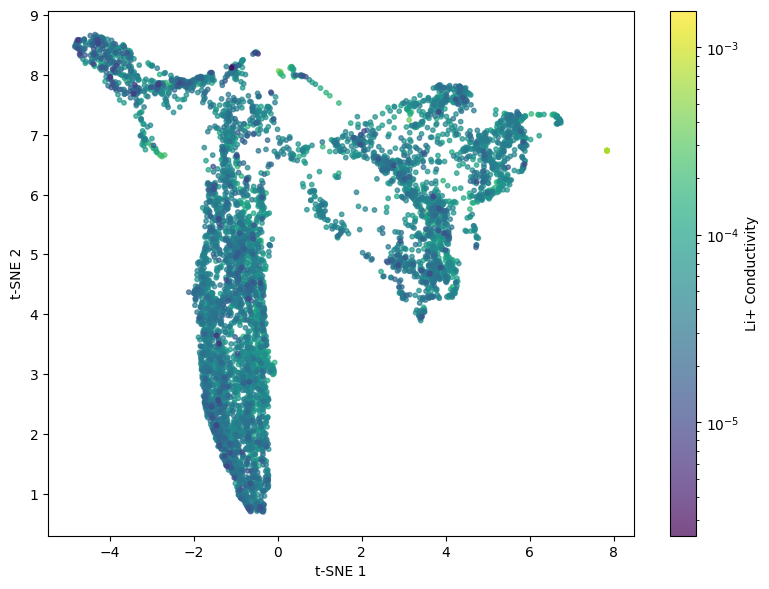

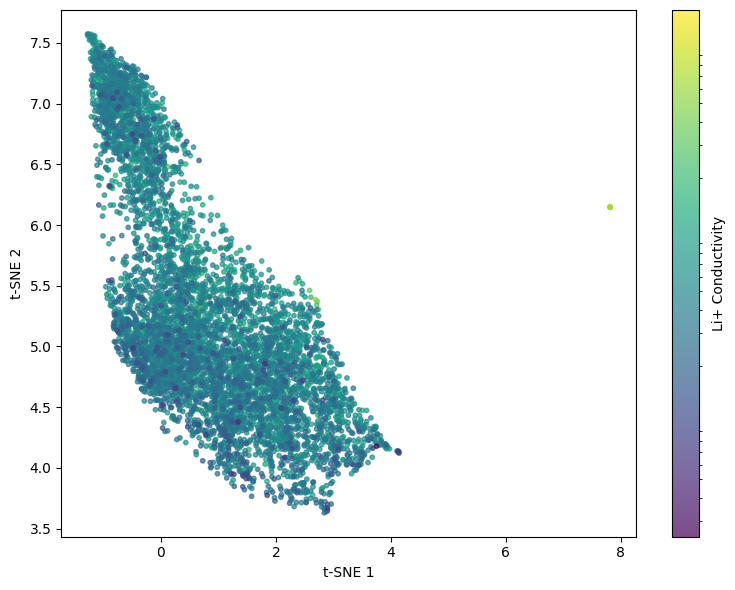

In [16]:
# Step 1: 라벨 생성
df = pd.read_csv("simulation-trajectory-aggregate_aligned.csv")
labels = df.iloc[:, 6:7].values.squeeze()
vmin, vmax = labels.min(), labels.max()  # 대개 -1.0, 0.5

#posterior mean
# --------------------- latent space plot with T-SNE ------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], 
                      c=labels, cmap='viridis', s=10, alpha=0.7,
                      norm=LogNorm(vmin=vmin, vmax=vmax) )  # 범위는 labels 값에 맞게

cbar = plt.colorbar(scatter)
cbar.set_label("Li+ Conductivity")

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

#posterior z
# --------------------- latent space plot with T-SNE ------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_z[:, 0], reduced_z[:, 1],
                      c=labels, cmap='viridis', s=10, alpha=0.7,
                      norm=LogNorm(vmin=vmin, vmax=vmax))  # 범위는 labels 값에 맞게



# Step 7: 컬러바 커스터마이징
cbar = plt.colorbar(scatter, ticks=np.arange(5))
cbar.ax.set_yticklabels(["-1.64", "0.00",  "0.22", "0.50", "1.10"])
cbar.set_label("Li+ Conductivity")

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

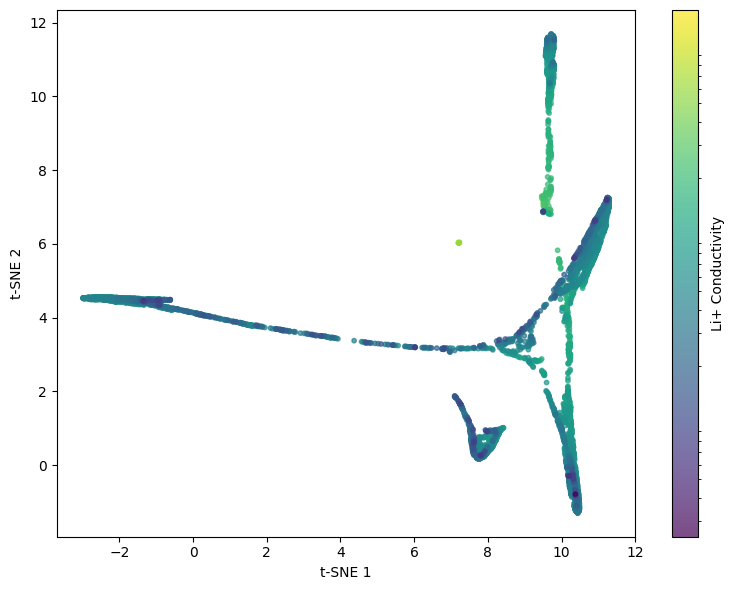

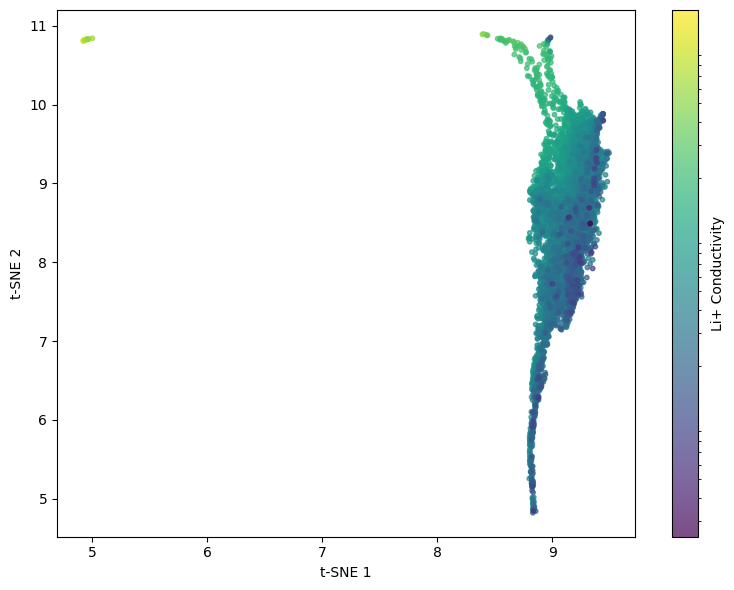

In [17]:
#prior mean
# --------------------- latent space plot with T-SNE ------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_p[:, 0], reduced_p[:, 1],
                      c=labels, cmap='viridis', s=10, alpha=0.7,
                      norm=LogNorm(vmin=vmin, vmax=vmax) )  # 범위는 labels 값에 맞게


# Step 7: 컬러바 커스터마이징
cbar = plt.colorbar(scatter, ticks=np.arange(5))
cbar.ax.set_yticklabels(["-1.64", "0.00",  "0.22", "0.50", "1.10"])
cbar.set_label("Li+ Conductivity")

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

#prior z
# --------------------- latent space plot with T-SNE ------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_z_p[:, 0], reduced_z_p[:, 1],
                      c=labels, cmap='viridis', s=10, alpha=0.7,
                      norm=LogNorm(vmin=vmin, vmax=vmax) )  # 범위는 labels 값에 맞게


# Step 7: 컬러바 커스터마이징
cbar = plt.colorbar(scatter, ticks=np.arange(5))
cbar.ax.set_yticklabels(["-1.64", "0.00",  "0.22", "0.50", "1.10"])
cbar.set_label("Li+ Conductivity")

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

In [16]:
from sklearn.linear_model import LinearRegression
df = pd.read_csv("simulation-trajectory-aggregate_aligned.csv")
cond = df.iloc[:,6:7].values.squeeze()
# μ 분산
mu_std = mean_tn.detach().view(-1, 64).std(0).mean()   # 목표 0.15-0.35
print(mu_std.item())
# z → conductivity 선형 R²
z_sent = z.detach().mean(1)
r2 = LinearRegression().fit(z_sent.cpu(), cond).score(z_sent.cpu(), cond)  # 목표 ≥0.3
print(r2)
# raw KLD per token
print(kld_raw.item())                                # 목표 capacity(0.2)+α


0.0815095454454422
0.6588291794623471


NameError: name 'kld_raw' is not defined

In [33]:
import math, random, torch, torch.nn.functional as F
from torch.distributions.normal import Normal
from scipy.linalg import sqrtm    # (W2 계산용)

PAD_IDX = 166
DEVICE  = next(model.parameters()).device       # 이미 학습된 model, prior 사용

# -------------------------------------------------------------
# 0. 헬퍼 함수
# -------------------------------------------------------------
def decode_tokens(model, z, dec_in, properties):
    prop_p = model.input_embedding(properties)
    dec    = model.decoder(model.to_decoder(z))
    return model.predict(dec)                  # [B, L, vocab]

def log_px_z(logits, target):
    ll = -F.cross_entropy(
        logits.transpose(1, 2), target,
        reduction='none', ignore_index=PAD_IDX
    )
    return ll.sum(dim=1)                       # [B]

@torch.no_grad()
def iwae_bound(model, prior, sm_enc, sm_dec_in, sm_dec_tgt, props, K=64):
    enc   = model.encoder(sm_enc, model.input_embedding(props))
    mu_q, lv_q = model.to_means(enc), model.to_var(enc)
    q     = Normal(mu_q, (0.5 * lv_q).exp())          # [B,L,D]
    mu_p, lv_p = prior(props.squeeze())
    p     = Normal(mu_p, (0.5 * lv_p).exp())

    log_ws = []
    for _ in range(K):
        z       = q.rsample()
        logits  = decode_tokens(model, z, sm_dec_in, props)
        log_px  = log_px_z(logits, sm_dec_tgt)         # [B]
        log_qz  = q.log_prob(z).sum((1, 2))
        log_pz  = p.log_prob(z).sum((1, 2))
        log_ws.append(log_px + log_pz - log_qz)        # [B]

    log_ws = torch.stack(log_ws)                       # [K,B]
    return torch.logsumexp(log_ws, 0) - math.log(K)    # [B]

@torch.no_grad()
def kl_decompose_minibatch(mu_b, lv_b, dataset_size):
    m, D = mu_b.size()
    q    = Normal(mu_b, (0.5 * lv_b).exp())
    z    = q.rsample()                                 # [m, D]

    log_q_ij = (-0.5 * (
        ((z[:, None] - mu_b[None]) ** 2) / lv_b.exp()[None]
        + lv_b[None] + math.log(2 * math.pi)
    ).sum(-1))                                         # [m, m]

    log_qz        = torch.logsumexp(log_q_ij, dim=1) - math.log(dataset_size)
    log_qz_prod   = q.log_prob(z).sum(-1)
    log_pz        = Normal(0, 1).log_prob(z).sum(-1)

    mi = (q.log_prob(z).sum(-1) - log_qz).mean()
    tc = (log_qz - log_qz_prod).mean()
    dw = (log_qz_prod - log_pz).mean()
    return {'MI': mi.item(), 'TC': tc.item(), 'DimKL': dw.item()}

def active_units(mu, eps=1e-2):
    return (mu.var(0) > eps).sum().item()

def _rbf(x, sigma):
    diff2 = ((x[:, None] - x[None]) ** 2).sum(-1)
    return torch.exp(-diff2 / (2 * sigma ** 2))

# ---------------------------------------------------
# RFF 기반 HSIC  (unbiased, ^2-norm kernel)
# ---------------------------------------------------
def hsic_rff(x, y, num_feat=512, sigma=None):
    """
    x : [N, Dx], y : [N, Dy]
    반환 : 스칼라 HSIC
    """
    N, Dx = x.shape
    Dy = y.shape[1]

    # ① adaptive sigma
    if sigma is None:
        sigma = 0.5 * (x.var(0, unbiased=False).mean().sqrt() +
                       y.var(0, unbiased=False).mean().sqrt())

    # ② Random Fourier Features
    w_x = torch.randn(Dx, num_feat, device=x.device) / sigma
    w_y = torch.randn(Dy, num_feat, device=y.device) / sigma
    b   = 2 * math.pi * torch.rand(num_feat, device=x.device)  # 공유 bias

    z_x = (x @ w_x + b).cos() * math.sqrt(2.0 / num_feat)      # [N, F]
    z_y = (y @ w_y + b).cos() * math.sqrt(2.0 / num_feat)

    # ③ 센터링
    z_xc = z_x - z_x.mean(0, keepdim=True)                     # [N, F]
    z_yc = z_y - z_y.mean(0, keepdim=True)

    # ④ Frobenius-norm 무편향 HSIC
    #    HSIC = || (1/N) Z_x^T Z_y ||_F^2
    C = (z_xc.T @ z_yc) / (N - 1)      # [F, F]
    return (C**2).sum()                # 스칼라

def get_random_batch(dataloader):
    idx = random.randrange(len(dataloader))
    for i, batch in enumerate(dataloader):
        if i == idx:
            return batch

# -------------------------------------------------------------
# 1. 무작위 배치 가져오기
# -------------------------------------------------------------
batch = get_random_batch(val_dataloader)       # (*batch 형태에 맞게 수정*)
sm_enc, sm_dec_in, sm_dec_tgt, props = (t.to(DEVICE) for t in batch)

# -------------------------------------------------------------
# 2. IWAE
# -------------------------------------------------------------
iwae = iwae_bound(model, prior, sm_enc, sm_dec_in, sm_dec_tgt, props).mean().item()
print(f"IWAE  : {iwae:.3f}")

# -------------------------------------------------------------
# 3. posterior 파라미터 & z 샘플
# -------------------------------------------------------------
with torch.no_grad():
    enc  = model.encoder(sm_enc, model.input_embedding(props))
    mu_q = model.to_means(enc)                       # [B,L,64]
    lv_q = model.to_var(enc)
    z    = model.reparameterize(mu_q, lv_q)          # [B,L,64]

mu_flat = mu_q.reshape(-1, 64).cpu()                 # [N,D] → CPU
lv_flat = lv_q.reshape(-1, 64).cpu()

# ----- KL 분해 (서브샘플 4096개) --------------------------
m = min(4096, mu_flat.size(0))
sub_idx   = torch.randint(0, mu_flat.size(0), (m,))
mu_sub, lv_sub = mu_flat[sub_idx].to(DEVICE), lv_flat[sub_idx].to(DEVICE)

dataset_size = len(val_dataloader.dataset)
kl_stats = kl_decompose_minibatch(mu_sub, lv_sub, dataset_size)
print("KL-decomp:", kl_stats)

# ----- Active Units --------------------------------------
au = active_units(mu_flat)
print(f"Active Units: {au}")

# -------------------------------------------------
# 1. z 플랫
# -------------------------------------------------
z_flat = z.reshape(-1, z.size(-1))           # [B*L, 64]

# -------------------------------------------------
# 2. props -> [B, P] 로 만든 뒤 토큰 수만큼 복제
#    (props 가 [B, 1] 이든 [B, 3] 이든 자동 처리)
# -------------------------------------------------
props_2d = props.reshape(props.size(0), -1)   # [B, P]
cond_flat = props_2d.repeat_interleave(z.size(1), 0)  # [B*L, P]

# -------------------------------------------------
# 3. HSIC(RFF) 계산
# -------------------------------------------------
m_rff = 512          # feature 개수
sigma_z = z_flat.var(0, unbiased=False).mean().sqrt()
sigma_c = cond_flat.var(0, unbiased=False).mean().sqrt()
sigma = (sigma_z + sigma_c) / 2          # 공통 밴드폭
sigma = sigma.item()

hsic_score = hsic_rff(z_flat, cond_flat, num_feat=m_rff, sigma=sigma).item()
print(f"HSIC_RFF(z,c): {hsic_score:.4f}")



IWAE  : -1536.223
KL-decomp: {'MI': -0.05551028624176979, 'TC': 0.05551028624176979, 'DimKL': 96.85767364501953}
Active Units: 13
HSIC_RFF(z,c): 0.0000
